In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

In [3]:
train_path = '/kaggle/input/adobetraindata/behaviour_simulation_train.csv'
test_path = '/kaggle/input/inter-iit-mid-prep-adobe/problem_1_test_dataset/behaviour_simulation_test_company.xlsx'

In [4]:
test_dataset = pd.read_excel(test_path)

In [5]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  int64 
 1   date              10000 non-null  object
 2   content           10000 non-null  object
 3   username          10000 non-null  object
 4   media             10000 non-null  object
 5   inferred company  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [6]:
train_dataset = pd.read_csv(train_path)

In [7]:
train_dataset

,id,date,likes,content,username,media,inferred company
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
...,...,...,...,...,...,...,...
299995,299996,2019-09-07 16:18:10,0,Barcelona Star Expected To Return Against Vale...,IndependentNGR,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
299996,299997,2018-02-23 11:24:36,46,Kjeld Nuis of #NED is golden again... This tim...,CBCOlympics,[Video(thumbnailUrl='https://pbs.twimg.com/med...,cbc
299997,299998,2020-11-11 20:18:15,261,Grateful 🙌🏾 to have <mention> officially join ...,TeamCoachBuzz,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
299998,299999,2019-10-29 10:44:00,119,The US Air Force's mysterious space plane just...,Independent,[Video(thumbnailUrl='https://pbs.twimg.com/med...,independent


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
# Load data
train_data = train_dataset.copy()
test_data = test_dataset.copy()
# Bin the likes into categories
# Define the cap threshold
cap_value = 20000
# Apply the cap to the 'likes' column
train_data['likes_capped'] = train_data['likes'].apply(lambda x: min(x, cap_value))
# Check the distribution of the capped 'likes' column
print(train_data['likes_capped'].describe())
bins = [0, 100, 1000, 10000, 100000]
labels = ['0-100', '101-1k','1k-10k','10k+']
train_data['likes_binned'] = pd.cut(train_data['likes_capped'], bins=bins, labels=labels, include_lowest=True)
# Sample 10% of the data, stratified by binned likes
sample_fraction = 0.01  # Change this to 1.0 for 100%
train_data_sampled, _ = train_test_split(train_data, test_size=1-sample_fraction, random_state=42, stratify=train_data['likes_binned'])
train_data_sampled = train_data_sampled.reset_index(drop=1)
train_data_sampled = train_data.copy()

# Check distribution
print(train_data_sampled['likes_binned'].value_counts(normalize=True))


count    300000.000000
mean        643.547447
std        2128.732465
min           0.000000
25%           3.000000
50%          76.000000
75%         364.000000
max       20000.000000
Name: likes_capped, dtype: float64
likes_binned
0-100     0.548557
101-1k    0.327200
1k-10k    0.111780
10k+      0.012463
Name: proportion, dtype: float64


In [9]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [10]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji

# Ensure you've downloaded necessary NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     # Remove user mentions
#     text = re.sub(r'@\w+', '', text)
#     # Remove non-letter characters
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def get_roberta_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy().flatten()

# def get_datetime_features(date_str):
#     date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
#     return np.array([
#         date.year, date.month, date.day, date.hour, date.minute,
#         date.weekday(), date.timetuple().tm_yday,
#         np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
#         np.cos(2 * np.pi * date.hour / 24),
#         np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
#         np.cos(2 * np.pi * date.month / 12)
#     ])

# def get_categorical_embedding(value, encoder):
#     return encoder.transform([[value]]).toarray().flatten()

# def create_graph_embedding(df):
#     G = nx.Graph()
#     for _, row in df.iterrows():
#         G.add_edge(row['username'], row['inferred company'])
#         for mention in re.findall(r'@(\w+)', row['content']):
#             G.add_edge(row['username'], mention)
    
#     node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
#     model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
#     def get_node_embedding(node):
#         try:
#             return model.wv[node]
#         except KeyError:
#             return np.zeros(64)
    
#     df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
#     df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
#     return df

# def extract_hashtags(text):
#     return ' '.join(re.findall(r'#(\w+)', text))

# def extract_emoji(text):
#     return ' '.join([c for c in text if c in emoji.UNICODE_EMOJI['en']])

# # Load the data
# df = pd.read_csv("tweets.csv")

# # Preprocess text
# df['processed_content'] = df['content'].apply(preprocess_text)
# df['hashtags'] = df['content'].apply(extract_hashtags)
# df['emojis'] = df['content'].apply(extract_emoji)

# # Combine all text data
# df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

# # Generate text embeddings
# df['combined_embedding'] = df['combined_text'].apply(get_roberta_embedding)

# # Generate datetime embeddings
# df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# # Generate categorical embeddings
# company_encoder = OneHotEncoder(sparse=False)
# company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

# # Generate graph embeddings
# df = create_graph_embedding(df)

# # Combine all embeddings
# df['rich_embedding'] = df.apply(lambda row: np.concatenate([
#     row['combined_embedding'],
#     row['datetime_embedding'],
#     row['company_embedding'],
#     row['user_graph_embedding'],
#     row['company_graph_embedding']
# ]), axis=1)

# print("Rich embeddings generated successfully!")
# print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

# # Optional: Dimensionality reduction if needed
# # from sklearn.decomposition import PCA
# # pca = PCA(n_components=100)
# # df['reduced_embedding'] = list(pca.fit_transform(np.stack(df['rich_embedding'])))

# # Save the embeddings
# np.save('rich_tweet_embeddings.npy', np.stack(df['rich_embedding']))
# df[['id', 'content', 'username', 'inferred company']].to_csv('tweet_metadata.csv', index=False)

# print("Embeddings and metadata saved successfully!")

In [12]:
# tokenize_username('AAASouthJersey')

In [13]:
# set(df['username'])

In [14]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load specialized Twitter model
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using device: cuda


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [15]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove non-letter characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def get_roberta_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_datetime_features(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    return np.array([
        date.year, date.month, date.day, date.hour, date.minute,
        date.weekday(), date.timetuple().tm_yday,
        np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
        np.cos(2 * np.pi * date.hour / 24),
        np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
        np.cos(2 * np.pi * date.month / 12)
    ])

def get_categorical_embedding(value, encoder):
    return encoder.transform([[value]]).flatten()

def create_graph_embedding(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['username'], row['inferred company'])
        for mention in re.findall(r'@(\w+)', row['content']):
            G.add_edge(row['username'], mention)
    
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    def get_node_embedding(node):
        try:
            return model.wv[node]
        except KeyError:
            return np.zeros(64)
    
    df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
    df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
    return df

def extract_hashtags(text):
    return ' '.join(re.findall(r'#(\w+)', text))

def extract_emoji(text):
    return ' '.join([c for c in text if emoji.is_emoji(c)])

In [16]:
# # Label encode the binned categories
# le = LabelEncoder()
# y = le.fit_transform(train_data_sampled['likes_binned'])

# # Define the groups based on the 'inferred_company'
# groups = train_data_sampled['inferred company']

# # Initialize GroupShuffleSplit with stratification
# gss = StratifiedGroupKFold(n_splits=5,shuffle=True, random_state=42)
# train_idx, val_idx = next(gss.split(train_data_sampled, train_data_sampled['likes_binned'], groups))
# # Perform the split
# # for train_idx, val_idx in gss.split(X_combined, y, groups):
# X_train, X_val = train_data_sampled.iloc[train_idx].reset_index(drop=True), train_data_sampled.iloc[val_idx].reset_index(drop=True)
# y_train, y_val = train_data_sampled['likes_capped'].iloc[train_idx].reset_index(drop=True), train_data_sampled['likes_capped'].iloc[val_idx].reset_index(drop=True)

# # Ensure stratification within the group-based split
# # print(f"Training set class distribution: {np.bincount(y_train)}")
# # print(f"Validation set class distribution: {np.bincount(y_val)}")

In [17]:
# Load the data
df = train_data_sampled.copy()

# Preprocess text and combine data
print("Preprocessing train text...")
df['processed_content'] = df['content'].apply(preprocess_text)
df['hashtags'] = df['content'].apply(extract_hashtags)
df['emojis'] = df['content'].apply(extract_emoji)
df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

Preprocessing train text...


In [18]:
# Generate embeddings with progress bar
print("Generating embeddings...")
embeddings = []
for text in tqdm(df['combined_text'], desc="Generating text embeddings"):
    embeddings.append(get_roberta_embedding(text))
df['combined_embedding'] = embeddings

Generating embeddings...


Generating text embeddings: 100%|██████████| 300000/300000 [42:50<00:00, 116.72it/s]


In [19]:
# Generate other embeddings
print("Generating other embeddings...")
df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# company_encoder = OneHotEncoder(sparse=False)
# company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

Generating other embeddings...


In [20]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import torch
from tqdm import tqdm  # For progress tracking

# Load the training data
# df = pd.read_csv("train_tweets.csv")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check for GPU

# 1. Tokenize usernames and perform word frequency analysis
def tokenize_username(username):
    username = username.replace('_', ' ')
    username_parts = re.findall(r'[A-Z][a-z]*|[a-z]+|\d+', username)
    return [word.lower() for word in username_parts]

df['tokenized_username'] = df['username'].apply(tokenize_username)

# 5. Username Embedding Generation using Pre-trained Model
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)  # Move model to GPU

def get_username_embedding(username):
    tokenized = tokenizer(username, return_tensors="pt", truncation=True, padding=True).to(device)  # Move inputs to GPU
    with torch.no_grad():
        outputs = model(**tokenized)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()  # Move back to CPU

# Apply embedding generation with progress tracking
df['username_embedding'] = [get_username_embedding(' '.join(tokenize_username(username))) for username in tqdm(df['username'], desc="Embedding Generation")]

# 6. Dimensionality Reduction with PCA
pca = PCA(n_components=64)
df['reduced_username_embedding'] = list(pca.fit_transform(np.stack(df['username_embedding'])))

# 7. Feature List
print("Training features generated successfully!")
print("Feature columns for use in neural network:")
print(df.columns)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Embedding Generation: 100%|██████████| 300000/300000 [40:40<00:00, 122.93it/s]


Training features generated successfully!
Feature columns for use in neural network:
Index(['id', 'date', 'likes', 'content', 'username', 'media',
       'inferred company', 'likes_capped', 'likes_binned', 'processed_content',
       'hashtags', 'emojis', 'combined_text', 'combined_embedding',
       'datetime_embedding', 'tokenized_username', 'username_embedding',
       'reduced_username_embedding'],
      dtype='object')


In [21]:
# Combine all embeddings
print("Combining embeddings...")
df['rich_embedding'] = df.apply(lambda row: np.concatenate([
    row['combined_embedding'],
    row['datetime_embedding'],
    row['reduced_username_embedding']
    # row['company_embedding']
    # row['user_graph_embedding'],
    # row['company_graph_embedding']
]), axis=1)

print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

Combining embeddings...
Shape of rich embedding: (843,)


In [22]:
pca.explained_variance_ratio_.sum()

0.871115549732658

In [23]:
# # Load the data
# df = X_val

# # Preprocess text and combine data
# print("Preprocessing val text...")
# df['processed_content'] = df['content'].apply(preprocess_text)
# df['hashtags'] = df['content'].apply(extract_hashtags)
# df['emojis'] = df['content'].apply(extract_emoji)
# df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

In [24]:
# # Generate embeddings with progress bar
# print("Generating embeddings...")
# embeddings = []
# for text in tqdm(df['combined_text'], desc="Generating text embeddings"):
#     embeddings.append(get_roberta_embedding(text))
# df['combined_embedding'] = embeddings

In [25]:
# # Generate other embeddings
# print("Generating other embeddings...")
# df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# # company_encoder = OneHotEncoder(sparse=False)
# # company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

In [26]:
# # Combine all embeddings
# print("Combining embeddings...")
# df['rich_embedding'] = df.apply(lambda row: np.concatenate([
#     row['combined_embedding'],
#     row['datetime_embedding'],
#     row['company_embedding']
#     # row['user_graph_embedding'],
#     # row['company_graph_embedding']
# ]), axis=1)

# print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

In [27]:
# print("Creating graph embeddings...")
# df = create_graph_embedding(df)

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Prepare data for regression
X = np.stack(df['rich_embedding'])
y = df['likes_capped'].values

# Log transform the target variable to handle skewness
y = np.log1p(y)  # log1p is used to handle zero values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
# Define a neural network for regression
class TweetLikesRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TweetLikesRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, likes):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.likes = torch.tensor(likes, dtype=torch.float32)
    
    def __len__(self):
        return len(self.likes)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.likes[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [31]:
# Create model, optimizer, and loss function
model = TweetLikesRegressor(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [32]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train_scaled, y_train)
val_dataset = TweetDataset(X_val_scaled, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [33]:
# Training loop
print("Training regression model...")
best_val_mse = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_likes in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_likes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_likes in val_loader:
            batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
            outputs = model(batch_embeddings)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(batch_likes.cpu().numpy())
    
    val_mse = mean_squared_error(val_true, val_preds)
    val_mae = mean_absolute_error(val_true, val_preds)
    val_r2 = r2_score(val_true, val_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    print(f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")
    
    # Save the best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), 'best_tweet_likes_regressor.pth')
        print("New best model saved!")

print("Training completed!")

Training regression model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:08<00:00, 419.32it/s]


Epoch 1/100, Loss: 1.6618
Val MSE: 1.0882, Val MAE: 0.7479, Val R2: 0.8393
New best model saved!


Epoch 2/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.19it/s]


Epoch 2/100, Loss: 1.2666
Val MSE: 1.0197, Val MAE: 0.7180, Val R2: 0.8494
New best model saved!


Epoch 3/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.66it/s]


Epoch 3/100, Loss: 1.1497
Val MSE: 1.0054, Val MAE: 0.7480, Val R2: 0.8515
New best model saved!


Epoch 4/100: 100%|██████████| 3750/3750 [00:08<00:00, 421.82it/s]


Epoch 4/100, Loss: 1.0796
Val MSE: 0.8593, Val MAE: 0.6669, Val R2: 0.8731
New best model saved!


Epoch 5/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.29it/s]


Epoch 5/100, Loss: 1.0290
Val MSE: 0.8622, Val MAE: 0.6779, Val R2: 0.8727


Epoch 6/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.48it/s]


Epoch 6/100, Loss: 0.9814
Val MSE: 0.8234, Val MAE: 0.6507, Val R2: 0.8784
New best model saved!


Epoch 7/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.06it/s]


Epoch 7/100, Loss: 0.9554
Val MSE: 0.8238, Val MAE: 0.6607, Val R2: 0.8784


Epoch 8/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.26it/s]


Epoch 8/100, Loss: 0.9324
Val MSE: 0.8195, Val MAE: 0.6409, Val R2: 0.8790
New best model saved!


Epoch 9/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.29it/s]


Epoch 9/100, Loss: 0.9068
Val MSE: 0.7945, Val MAE: 0.6548, Val R2: 0.8827
New best model saved!


Epoch 10/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.94it/s]


Epoch 10/100, Loss: 0.8898
Val MSE: 0.7739, Val MAE: 0.6205, Val R2: 0.8857
New best model saved!


Epoch 11/100: 100%|██████████| 3750/3750 [00:08<00:00, 419.79it/s]


Epoch 11/100, Loss: 0.8699
Val MSE: 0.8044, Val MAE: 0.6616, Val R2: 0.8812


Epoch 12/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.16it/s]


Epoch 12/100, Loss: 0.8571
Val MSE: 0.7714, Val MAE: 0.6384, Val R2: 0.8861
New best model saved!


Epoch 13/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.59it/s]


Epoch 13/100, Loss: 0.8479
Val MSE: 0.8616, Val MAE: 0.7027, Val R2: 0.8728


Epoch 14/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.83it/s]


Epoch 14/100, Loss: 0.8319
Val MSE: 0.7382, Val MAE: 0.6179, Val R2: 0.8910
New best model saved!


Epoch 15/100: 100%|██████████| 3750/3750 [00:08<00:00, 427.70it/s]


Epoch 15/100, Loss: 0.8213
Val MSE: 0.8006, Val MAE: 0.6218, Val R2: 0.8818


Epoch 16/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.08it/s]


Epoch 16/100, Loss: 0.8090
Val MSE: 0.7411, Val MAE: 0.6010, Val R2: 0.8906


Epoch 17/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.28it/s]


Epoch 17/100, Loss: 0.8027
Val MSE: 0.7348, Val MAE: 0.6133, Val R2: 0.8915
New best model saved!


Epoch 18/100: 100%|██████████| 3750/3750 [00:08<00:00, 421.79it/s]


Epoch 18/100, Loss: 0.7952
Val MSE: 0.7491, Val MAE: 0.6078, Val R2: 0.8894


Epoch 19/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.06it/s]


Epoch 19/100, Loss: 0.7852
Val MSE: 0.7431, Val MAE: 0.6009, Val R2: 0.8903


Epoch 20/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.01it/s]


Epoch 20/100, Loss: 0.7782
Val MSE: 0.7316, Val MAE: 0.6201, Val R2: 0.8920
New best model saved!


Epoch 21/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.62it/s]


Epoch 21/100, Loss: 0.7726
Val MSE: 0.7741, Val MAE: 0.6145, Val R2: 0.8857


Epoch 22/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.79it/s]


Epoch 22/100, Loss: 0.7657
Val MSE: 0.7157, Val MAE: 0.6071, Val R2: 0.8943
New best model saved!


Epoch 23/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.43it/s]


Epoch 23/100, Loss: 0.7603
Val MSE: 0.7213, Val MAE: 0.6129, Val R2: 0.8935


Epoch 24/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.56it/s]


Epoch 24/100, Loss: 0.7547
Val MSE: 0.7502, Val MAE: 0.6056, Val R2: 0.8892


Epoch 25/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.11it/s]


Epoch 25/100, Loss: 0.7485
Val MSE: 0.7245, Val MAE: 0.6085, Val R2: 0.8930


Epoch 26/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.46it/s]


Epoch 26/100, Loss: 0.7423
Val MSE: 0.7186, Val MAE: 0.5944, Val R2: 0.8939


Epoch 27/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.66it/s]


Epoch 27/100, Loss: 0.7384
Val MSE: 0.7104, Val MAE: 0.5990, Val R2: 0.8951
New best model saved!


Epoch 28/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.56it/s]


Epoch 28/100, Loss: 0.7330
Val MSE: 0.7587, Val MAE: 0.6139, Val R2: 0.8880


Epoch 29/100: 100%|██████████| 3750/3750 [00:08<00:00, 423.74it/s]


Epoch 29/100, Loss: 0.7267
Val MSE: 0.7062, Val MAE: 0.5961, Val R2: 0.8957
New best model saved!


Epoch 30/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.80it/s]


Epoch 30/100, Loss: 0.7230
Val MSE: 0.7119, Val MAE: 0.6074, Val R2: 0.8949


Epoch 31/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.40it/s]


Epoch 31/100, Loss: 0.7178
Val MSE: 0.7063, Val MAE: 0.6039, Val R2: 0.8957


Epoch 32/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.23it/s]


Epoch 32/100, Loss: 0.7154
Val MSE: 0.7264, Val MAE: 0.5917, Val R2: 0.8927


Epoch 33/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.29it/s]


Epoch 33/100, Loss: 0.7082
Val MSE: 0.7119, Val MAE: 0.5870, Val R2: 0.8949


Epoch 34/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.80it/s]


Epoch 34/100, Loss: 0.7088
Val MSE: 0.7199, Val MAE: 0.5990, Val R2: 0.8937


Epoch 35/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.25it/s]


Epoch 35/100, Loss: 0.6992
Val MSE: 0.7018, Val MAE: 0.6000, Val R2: 0.8964
New best model saved!


Epoch 36/100: 100%|██████████| 3750/3750 [00:08<00:00, 422.50it/s]


Epoch 36/100, Loss: 0.6961
Val MSE: 0.7118, Val MAE: 0.6018, Val R2: 0.8949


Epoch 37/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.02it/s]


Epoch 37/100, Loss: 0.6922
Val MSE: 0.7047, Val MAE: 0.5860, Val R2: 0.8959


Epoch 38/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.41it/s]


Epoch 38/100, Loss: 0.6867
Val MSE: 0.7109, Val MAE: 0.6109, Val R2: 0.8950


Epoch 39/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.05it/s]


Epoch 39/100, Loss: 0.6858
Val MSE: 0.7058, Val MAE: 0.5897, Val R2: 0.8958


Epoch 40/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.09it/s]


Epoch 40/100, Loss: 0.6819
Val MSE: 0.7028, Val MAE: 0.6060, Val R2: 0.8962


Epoch 41/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.65it/s]


Epoch 41/100, Loss: 0.6798
Val MSE: 0.6974, Val MAE: 0.5910, Val R2: 0.8970
New best model saved!


Epoch 42/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.60it/s]


Epoch 42/100, Loss: 0.6724
Val MSE: 0.7142, Val MAE: 0.5885, Val R2: 0.8945


Epoch 43/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.59it/s]


Epoch 43/100, Loss: 0.6739
Val MSE: 0.7458, Val MAE: 0.6373, Val R2: 0.8899


Epoch 44/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.02it/s]


Epoch 44/100, Loss: 0.6699
Val MSE: 0.7136, Val MAE: 0.5889, Val R2: 0.8946


Epoch 45/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.73it/s]


Epoch 45/100, Loss: 0.6646
Val MSE: 0.7326, Val MAE: 0.5980, Val R2: 0.8918


Epoch 46/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.10it/s]


Epoch 46/100, Loss: 0.6645
Val MSE: 0.7110, Val MAE: 0.6063, Val R2: 0.8950


Epoch 47/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.02it/s]


Epoch 47/100, Loss: 0.6606
Val MSE: 0.7111, Val MAE: 0.6040, Val R2: 0.8950


Epoch 48/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.54it/s]


Epoch 48/100, Loss: 0.6616
Val MSE: 0.7009, Val MAE: 0.5979, Val R2: 0.8965


Epoch 49/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.94it/s]


Epoch 49/100, Loss: 0.6545
Val MSE: 0.6997, Val MAE: 0.5907, Val R2: 0.8967


Epoch 50/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.24it/s]


Epoch 50/100, Loss: 0.6526
Val MSE: 0.7084, Val MAE: 0.5907, Val R2: 0.8954


Epoch 51/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.34it/s]


Epoch 51/100, Loss: 0.6509
Val MSE: 0.7457, Val MAE: 0.6162, Val R2: 0.8899


Epoch 52/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.80it/s]


Epoch 52/100, Loss: 0.6473
Val MSE: 0.7481, Val MAE: 0.5992, Val R2: 0.8896


Epoch 53/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.31it/s]


Epoch 53/100, Loss: 0.6456
Val MSE: 0.7384, Val MAE: 0.6123, Val R2: 0.8910


Epoch 54/100: 100%|██████████| 3750/3750 [00:09<00:00, 413.48it/s]


Epoch 54/100, Loss: 0.6432
Val MSE: 0.7146, Val MAE: 0.6055, Val R2: 0.8945


Epoch 55/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.09it/s]


Epoch 55/100, Loss: 0.6401
Val MSE: 0.7229, Val MAE: 0.6169, Val R2: 0.8933


Epoch 56/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.17it/s]


Epoch 56/100, Loss: 0.6388
Val MSE: 0.7152, Val MAE: 0.6082, Val R2: 0.8944


Epoch 57/100: 100%|██████████| 3750/3750 [00:08<00:00, 423.15it/s]


Epoch 57/100, Loss: 0.6359
Val MSE: 0.7386, Val MAE: 0.5961, Val R2: 0.8909


Epoch 58/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.02it/s]


Epoch 58/100, Loss: 0.6326
Val MSE: 0.7060, Val MAE: 0.6051, Val R2: 0.8958


Epoch 59/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.53it/s]


Epoch 59/100, Loss: 0.6297
Val MSE: 0.7050, Val MAE: 0.5944, Val R2: 0.8959


Epoch 60/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.11it/s]


Epoch 60/100, Loss: 0.6322
Val MSE: 0.7055, Val MAE: 0.6064, Val R2: 0.8958


Epoch 61/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.43it/s]


Epoch 61/100, Loss: 0.6240
Val MSE: 0.7065, Val MAE: 0.5933, Val R2: 0.8957


Epoch 62/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.64it/s]


Epoch 62/100, Loss: 0.6246
Val MSE: 0.7048, Val MAE: 0.5862, Val R2: 0.8959


Epoch 63/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.72it/s]


Epoch 63/100, Loss: 0.6209
Val MSE: 0.7232, Val MAE: 0.5951, Val R2: 0.8932


Epoch 64/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.41it/s]


Epoch 64/100, Loss: 0.6223
Val MSE: 0.7020, Val MAE: 0.5965, Val R2: 0.8964


Epoch 65/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.91it/s]


Epoch 65/100, Loss: 0.6145
Val MSE: 0.7031, Val MAE: 0.5958, Val R2: 0.8962


Epoch 66/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.93it/s]


Epoch 66/100, Loss: 0.6146
Val MSE: 0.7080, Val MAE: 0.6022, Val R2: 0.8955


Epoch 67/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.13it/s]


Epoch 67/100, Loss: 0.6178
Val MSE: 0.7347, Val MAE: 0.6015, Val R2: 0.8915


Epoch 68/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.50it/s]


Epoch 68/100, Loss: 0.6151
Val MSE: 0.7090, Val MAE: 0.6077, Val R2: 0.8953


Epoch 69/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.52it/s]


Epoch 69/100, Loss: 0.6126
Val MSE: 0.7230, Val MAE: 0.6134, Val R2: 0.8932


Epoch 70/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.85it/s]


Epoch 70/100, Loss: 0.6152
Val MSE: 0.7035, Val MAE: 0.5905, Val R2: 0.8961


Epoch 71/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.05it/s]


Epoch 71/100, Loss: 0.6060
Val MSE: 0.7302, Val MAE: 0.6108, Val R2: 0.8922


Epoch 72/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.63it/s]


Epoch 72/100, Loss: 0.6048
Val MSE: 0.7141, Val MAE: 0.6051, Val R2: 0.8946


Epoch 73/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.70it/s]


Epoch 73/100, Loss: 0.6023
Val MSE: 0.7273, Val MAE: 0.5907, Val R2: 0.8926


Epoch 74/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.62it/s]


Epoch 74/100, Loss: 0.6007
Val MSE: 0.7008, Val MAE: 0.5936, Val R2: 0.8965


Epoch 75/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.74it/s]


Epoch 75/100, Loss: 0.5978
Val MSE: 0.7191, Val MAE: 0.5902, Val R2: 0.8938


Epoch 76/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.23it/s]


Epoch 76/100, Loss: 0.5978
Val MSE: 0.7345, Val MAE: 0.6021, Val R2: 0.8916


Epoch 77/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.28it/s]


Epoch 77/100, Loss: 0.5960
Val MSE: 0.7126, Val MAE: 0.5973, Val R2: 0.8948


Epoch 78/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.73it/s]


Epoch 78/100, Loss: 0.5918
Val MSE: 0.7073, Val MAE: 0.5986, Val R2: 0.8956


Epoch 79/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.92it/s]


Epoch 79/100, Loss: 0.5896
Val MSE: 0.7583, Val MAE: 0.6460, Val R2: 0.8880


Epoch 80/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.00it/s]


Epoch 80/100, Loss: 0.5906
Val MSE: 0.7071, Val MAE: 0.5949, Val R2: 0.8956


Epoch 81/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.37it/s]


Epoch 81/100, Loss: 0.5860
Val MSE: 0.7868, Val MAE: 0.6157, Val R2: 0.8838


Epoch 82/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.27it/s]


Epoch 82/100, Loss: 0.5842
Val MSE: 0.7008, Val MAE: 0.5842, Val R2: 0.8965


Epoch 83/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.69it/s]


Epoch 83/100, Loss: 0.5868
Val MSE: 0.7074, Val MAE: 0.5946, Val R2: 0.8955


Epoch 84/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.54it/s]


Epoch 84/100, Loss: 0.5877
Val MSE: 0.7170, Val MAE: 0.5921, Val R2: 0.8941


Epoch 85/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.73it/s]


Epoch 85/100, Loss: 0.5839
Val MSE: 0.7477, Val MAE: 0.6359, Val R2: 0.8896


Epoch 86/100: 100%|██████████| 3750/3750 [00:08<00:00, 423.73it/s]


Epoch 86/100, Loss: 0.5818
Val MSE: 0.7144, Val MAE: 0.6080, Val R2: 0.8945


Epoch 87/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.79it/s]


Epoch 87/100, Loss: 0.5792
Val MSE: 0.7000, Val MAE: 0.5862, Val R2: 0.8966


Epoch 88/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.91it/s]


Epoch 88/100, Loss: 0.5816
Val MSE: 0.7083, Val MAE: 0.5923, Val R2: 0.8954


Epoch 89/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.94it/s]


Epoch 89/100, Loss: 0.5751
Val MSE: 0.7377, Val MAE: 0.6242, Val R2: 0.8911


Epoch 90/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.20it/s]


Epoch 90/100, Loss: 0.5752
Val MSE: 0.7237, Val MAE: 0.5904, Val R2: 0.8932


Epoch 91/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.32it/s]


Epoch 91/100, Loss: 0.5727
Val MSE: 0.7123, Val MAE: 0.6005, Val R2: 0.8948


Epoch 92/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.79it/s]


Epoch 92/100, Loss: 0.5706
Val MSE: 0.7188, Val MAE: 0.6085, Val R2: 0.8939


Epoch 93/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.27it/s]


Epoch 93/100, Loss: 0.5699
Val MSE: 0.7120, Val MAE: 0.6008, Val R2: 0.8949


Epoch 94/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.08it/s]


Epoch 94/100, Loss: 0.5639
Val MSE: 0.7223, Val MAE: 0.5955, Val R2: 0.8934


Epoch 95/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.19it/s]


Epoch 95/100, Loss: 0.5666
Val MSE: 0.7255, Val MAE: 0.5919, Val R2: 0.8929


Epoch 96/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.72it/s]


Epoch 96/100, Loss: 0.5656
Val MSE: 0.7229, Val MAE: 0.5989, Val R2: 0.8933


Epoch 97/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.66it/s]


Epoch 97/100, Loss: 0.5664
Val MSE: 0.7190, Val MAE: 0.5997, Val R2: 0.8938


Epoch 98/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.96it/s]


Epoch 98/100, Loss: 0.5632
Val MSE: 0.7261, Val MAE: 0.6179, Val R2: 0.8928


Epoch 99/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.90it/s]


Epoch 99/100, Loss: 0.5613
Val MSE: 0.7297, Val MAE: 0.6140, Val R2: 0.8923


Epoch 100/100: 100%|██████████| 3750/3750 [00:08<00:00, 420.40it/s]


Epoch 100/100, Loss: 0.5589
Val MSE: 0.7546, Val MAE: 0.6002, Val R2: 0.8886
Training completed!


In [34]:
# Function to get predictions for new data
def predict_likes(new_data):
    model.eval()
    with torch.no_grad():
        new_data_scaled = scaler.transform(new_data)
        embeddings = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        # Convert log predictions back to original scale
        return np.expm1(outputs.cpu().numpy())

# Example usage:
# new_likes_predictions = predict_likes(new_embeddings)
model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))
# Evaluate on test set
model.eval()
test_preds = []
test_true = y_val  # Using validation set as test set for this example
with torch.no_grad():
    for batch_embeddings, batch_likes in val_loader:
        batch_embeddings = batch_embeddings.to(device)
        outputs = model(batch_embeddings)
        test_preds.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
test_preds = np.expm1(test_preds)
test_true = np.expm1(test_true)

# Calculate metrics on original scale
test_mse = mean_squared_error(test_true, test_preds)
test_mae = mean_absolute_error(test_true, test_preds)
test_r2 = r2_score(test_true, test_preds)

print("\nTest Set Evaluation (Original Scale):")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R2: {test_r2:.4f}")

# Calculate custom metrics for skewed data
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_true, test_preds)
mdape = median_absolute_percentage_error(test_true, test_preds)

print(f"MAPE: {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")

/tmp/ipykernel_23/1035189463.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))



Test Set Evaluation (Original Scale):
MSE: 2776206.53
MAE: 417.56
R2: 0.3742
MAPE: inf%
MdAPE: 59.54%


/tmp/ipykernel_23/1035189463.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/tmp/ipykernel_23/1035189463.py:43: RuntimeWarning: divide by zero encountered in divide
  return np.median(np.abs((y_true - y_pred) / y_true)) * 100


In [35]:
temp_df = pd.DataFrame(test_preds)
temp_df.describe()

,0
count,60000.000000
mean,435.686462
std,1547.666504
min,-0.538110
25%,2.682504
50%,95.246822
75%,281.454330
max,71928.179688


In [36]:
temp_df = pd.DataFrame(test_true)
temp_df.describe()

,0
count,60000.000000
mean,641.619100
std,2106.301879
min,0.000000
25%,3.000000
50%,77.000000
75%,364.000000
max,20000.000000


In [37]:
# Calculate Pearson correlation coefficient
correlation = np.corrcoef(test_preds, test_true)[0,1]

print(f"Pearson correlation: {correlation}")

Pearson correlation: 0.6285460581789757


In [38]:
import matplotlib.pyplot as plt

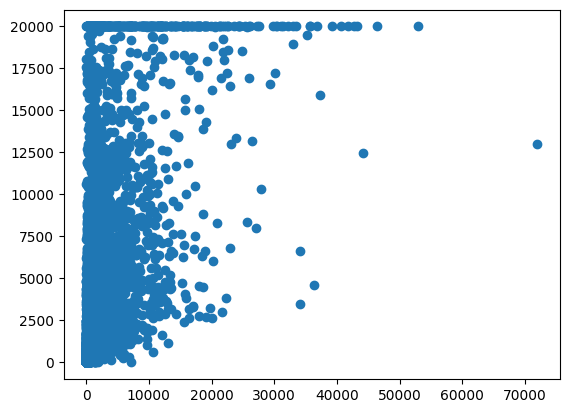

In [39]:
plt.scatter(test_preds,test_true)

In [40]:
# Prepare data for classification
X = np.stack(df['rich_embedding'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['likes_binned'])  # Assuming 'y' column exists with class labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Define a simple neural network for classification
class TweetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TweetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
num_classes = len(np.unique(y))
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [42]:
# Create model, optimizer, and loss function
model = TweetClassifier(input_dim, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [43]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [44]:
# Training loop
print("Training classification model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_labels in val_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            outputs = model(batch_embeddings)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(batch_labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Training completed!")

# Save the model
torch.save(model.state_dict(), 'tweet_classifier.pth')
print("Model saved successfully!")

# Function to get predictions for new data
def predict(new_data):
    model.eval()
    with torch.no_grad():
        embeddings = torch.tensor(new_data, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, 1)
    return label_encoder.inverse_transform(preds.cpu().numpy())

# Example usage:
# new_predictions = predict(new_embeddings)

Training classification model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 0.9239, Val Accuracy: 0.6934
Precision: 0.6282, Recall: 0.6934, F1-score: 0.6551


Epoch 2/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 0.8105, Val Accuracy: 0.6976
Precision: 0.6110, Recall: 0.6976, F1-score: 0.6514


Epoch 3/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.49it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 0.8022, Val Accuracy: 0.7006
Precision: 0.6253, Recall: 0.7006, F1-score: 0.6592


Epoch 4/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 0.7995, Val Accuracy: 0.6924
Precision: 0.6023, Recall: 0.6924, F1-score: 0.6439


Epoch 5/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 0.7961, Val Accuracy: 0.7023
Precision: 0.6490, Recall: 0.7023, F1-score: 0.6659


Epoch 6/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 0.7942, Val Accuracy: 0.6990
Precision: 0.6583, Recall: 0.6990, F1-score: 0.6644


Epoch 7/100: 100%|██████████| 3750/3750 [00:07<00:00, 488.85it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 0.7934, Val Accuracy: 0.7037
Precision: 0.6506, Recall: 0.7037, F1-score: 0.6673


Epoch 8/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 0.7892, Val Accuracy: 0.7081
Precision: 0.6519, Recall: 0.7081, F1-score: 0.6709


Epoch 9/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 0.7873, Val Accuracy: 0.7074
Precision: 0.6562, Recall: 0.7074, F1-score: 0.6710


Epoch 10/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.83it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 0.7866, Val Accuracy: 0.7114
Precision: 0.6323, Recall: 0.7114, F1-score: 0.6684


Epoch 11/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.22it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 0.7863, Val Accuracy: 0.7102
Precision: 0.6570, Recall: 0.7102, F1-score: 0.6734


Epoch 12/100: 100%|██████████| 3750/3750 [00:08<00:00, 450.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 0.7841, Val Accuracy: 0.7093
Precision: 0.6598, Recall: 0.7093, F1-score: 0.6730


Epoch 13/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 0.7847, Val Accuracy: 0.7123
Precision: 0.6372, Recall: 0.7123, F1-score: 0.6706


Epoch 14/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 0.7828, Val Accuracy: 0.7070
Precision: 0.6215, Recall: 0.7070, F1-score: 0.6614


Epoch 15/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 0.7831, Val Accuracy: 0.7129
Precision: 0.6604, Recall: 0.7129, F1-score: 0.6760


Epoch 16/100: 100%|██████████| 3750/3750 [00:08<00:00, 451.92it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 0.7814, Val Accuracy: 0.7117
Precision: 0.6385, Recall: 0.7117, F1-score: 0.6706


Epoch 17/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 0.7827, Val Accuracy: 0.7052
Precision: 0.6162, Recall: 0.7052, F1-score: 0.6577


Epoch 18/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.12it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 0.7815, Val Accuracy: 0.7065
Precision: 0.6162, Recall: 0.7065, F1-score: 0.6582


Epoch 19/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.89it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 0.7807, Val Accuracy: 0.7120
Precision: 0.6585, Recall: 0.7120, F1-score: 0.6750


Epoch 20/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 0.7800, Val Accuracy: 0.7147
Precision: 0.6433, Recall: 0.7147, F1-score: 0.6740


Epoch 21/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 0.7787, Val Accuracy: 0.7082
Precision: 0.6600, Recall: 0.7082, F1-score: 0.6722


Epoch 22/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.39it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 0.7788, Val Accuracy: 0.7160
Precision: 0.6499, Recall: 0.7160, F1-score: 0.6765


Epoch 23/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.74it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 0.7783, Val Accuracy: 0.7181
Precision: 0.6482, Recall: 0.7181, F1-score: 0.6777


Epoch 24/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.42it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 0.7771, Val Accuracy: 0.7190
Precision: 0.6470, Recall: 0.7190, F1-score: 0.6780


Epoch 25/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.48it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 0.7779, Val Accuracy: 0.7147
Precision: 0.6629, Recall: 0.7147, F1-score: 0.6778


Epoch 26/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 0.7777, Val Accuracy: 0.7150
Precision: 0.6303, Recall: 0.7150, F1-score: 0.6698


Epoch 27/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.56it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 0.7759, Val Accuracy: 0.7151
Precision: 0.6375, Recall: 0.7151, F1-score: 0.6726


Epoch 28/100: 100%|██████████| 3750/3750 [00:07<00:00, 470.08it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 0.7770, Val Accuracy: 0.7194
Precision: 0.6515, Recall: 0.7194, F1-score: 0.6793


Epoch 29/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.04it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 0.7767, Val Accuracy: 0.7058
Precision: 0.6796, Recall: 0.7058, F1-score: 0.6720


Epoch 30/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.64it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 0.7761, Val Accuracy: 0.7161
Precision: 0.6323, Recall: 0.7161, F1-score: 0.6713


Epoch 31/100: 100%|██████████| 3750/3750 [00:08<00:00, 460.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 0.7750, Val Accuracy: 0.7192
Precision: 0.6471, Recall: 0.7192, F1-score: 0.6782


Epoch 32/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.00it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 0.7749, Val Accuracy: 0.7152
Precision: 0.6311, Recall: 0.7152, F1-score: 0.6702


Epoch 33/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 0.7743, Val Accuracy: 0.7182
Precision: 0.6647, Recall: 0.7182, F1-score: 0.6809


Epoch 34/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 0.7752, Val Accuracy: 0.7194
Precision: 0.6628, Recall: 0.7194, F1-score: 0.6814


Epoch 35/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 0.7743, Val Accuracy: 0.7208
Precision: 0.6422, Recall: 0.7208, F1-score: 0.6778


Epoch 36/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 0.7724, Val Accuracy: 0.7217
Precision: 0.6496, Recall: 0.7217, F1-score: 0.6806


Epoch 37/100: 100%|██████████| 3750/3750 [00:07<00:00, 472.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 0.7728, Val Accuracy: 0.7184
Precision: 0.6683, Recall: 0.7184, F1-score: 0.6815


Epoch 38/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 0.7743, Val Accuracy: 0.7197
Precision: 0.6400, Recall: 0.7197, F1-score: 0.6763


Epoch 39/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 0.7725, Val Accuracy: 0.7183
Precision: 0.6712, Recall: 0.7183, F1-score: 0.6818


Epoch 40/100: 100%|██████████| 3750/3750 [00:08<00:00, 465.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 0.7720, Val Accuracy: 0.7208
Precision: 0.6444, Recall: 0.7208, F1-score: 0.6785


Epoch 41/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 0.7706, Val Accuracy: 0.7214
Precision: 0.6512, Recall: 0.7214, F1-score: 0.6808


Epoch 42/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 0.7717, Val Accuracy: 0.7225
Precision: 0.6484, Recall: 0.7225, F1-score: 0.6808


Epoch 43/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 0.7711, Val Accuracy: 0.7233
Precision: 0.6515, Recall: 0.7233, F1-score: 0.6822


Epoch 44/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.04it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 0.7706, Val Accuracy: 0.7196
Precision: 0.6490, Recall: 0.7196, F1-score: 0.6789


Epoch 45/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 0.7718, Val Accuracy: 0.7200
Precision: 0.6686, Recall: 0.7200, F1-score: 0.6828


Epoch 46/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.26it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 0.7715, Val Accuracy: 0.7204
Precision: 0.6418, Recall: 0.7204, F1-score: 0.6774


Epoch 47/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.87it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 0.7713, Val Accuracy: 0.7209
Precision: 0.6556, Recall: 0.7209, F1-score: 0.6814


Epoch 48/100: 100%|██████████| 3750/3750 [00:07<00:00, 470.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 0.7699, Val Accuracy: 0.7138
Precision: 0.6679, Recall: 0.7138, F1-score: 0.6778


Epoch 49/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.17it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 0.7706, Val Accuracy: 0.7218
Precision: 0.6593, Recall: 0.7218, F1-score: 0.6828


Epoch 50/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.27it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 0.7730, Val Accuracy: 0.7173
Precision: 0.6330, Recall: 0.7173, F1-score: 0.6722


Epoch 51/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.61it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 0.7702, Val Accuracy: 0.7041
Precision: 0.6864, Recall: 0.7041, F1-score: 0.6708


Epoch 52/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 0.7702, Val Accuracy: 0.7178
Precision: 0.6694, Recall: 0.7178, F1-score: 0.6811


Epoch 53/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 0.7705, Val Accuracy: 0.7225
Precision: 0.6542, Recall: 0.7225, F1-score: 0.6822


Epoch 54/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 0.7708, Val Accuracy: 0.7238
Precision: 0.6461, Recall: 0.7238, F1-score: 0.6810


Epoch 55/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 0.7697, Val Accuracy: 0.7235
Precision: 0.6598, Recall: 0.7235, F1-score: 0.6841


Epoch 56/100: 100%|██████████| 3750/3750 [00:08<00:00, 468.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 0.7699, Val Accuracy: 0.7096
Precision: 0.6715, Recall: 0.7096, F1-score: 0.6746


Epoch 57/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.08it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 0.7695, Val Accuracy: 0.7157
Precision: 0.6306, Recall: 0.7157, F1-score: 0.6702


Epoch 58/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 0.7707, Val Accuracy: 0.7238
Precision: 0.6486, Recall: 0.7238, F1-score: 0.6817


Epoch 59/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 0.7701, Val Accuracy: 0.7224
Precision: 0.6456, Recall: 0.7224, F1-score: 0.6799


Epoch 60/100: 100%|██████████| 3750/3750 [00:07<00:00, 472.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 0.7697, Val Accuracy: 0.7234
Precision: 0.6504, Recall: 0.7234, F1-score: 0.6819


Epoch 61/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.92it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 0.7691, Val Accuracy: 0.7214
Precision: 0.6422, Recall: 0.7214, F1-score: 0.6782


Epoch 62/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.16it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 0.7692, Val Accuracy: 0.7228
Precision: 0.6488, Recall: 0.7228, F1-score: 0.6812


Epoch 63/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 0.7684, Val Accuracy: 0.7213
Precision: 0.6425, Recall: 0.7213, F1-score: 0.6782


Epoch 64/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.41it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 0.7686, Val Accuracy: 0.7236
Precision: 0.6607, Recall: 0.7236, F1-score: 0.6844


Epoch 65/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 0.7692, Val Accuracy: 0.7248
Precision: 0.6560, Recall: 0.7248, F1-score: 0.6844


Epoch 66/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 0.7685, Val Accuracy: 0.7216
Precision: 0.6655, Recall: 0.7216, F1-score: 0.6836


Epoch 67/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 0.7696, Val Accuracy: 0.7206
Precision: 0.6620, Recall: 0.7206, F1-score: 0.6823


Epoch 68/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.63it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 0.7691, Val Accuracy: 0.7235
Precision: 0.6621, Recall: 0.7235, F1-score: 0.6846


Epoch 69/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.48it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 0.7690, Val Accuracy: 0.7234
Precision: 0.6604, Recall: 0.7234, F1-score: 0.6842


Epoch 70/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 0.7686, Val Accuracy: 0.7137
Precision: 0.6757, Recall: 0.7137, F1-score: 0.6784


Epoch 71/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.42it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 0.7688, Val Accuracy: 0.7211
Precision: 0.6413, Recall: 0.7211, F1-score: 0.6776


Epoch 72/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.92it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 0.7686, Val Accuracy: 0.7186
Precision: 0.6774, Recall: 0.7186, F1-score: 0.6827


Epoch 73/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 0.7674, Val Accuracy: 0.7221
Precision: 0.6707, Recall: 0.7221, F1-score: 0.6848


Epoch 74/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 0.7666, Val Accuracy: 0.7204
Precision: 0.6375, Recall: 0.7204, F1-score: 0.6758


Epoch 75/100: 100%|██████████| 3750/3750 [00:07<00:00, 487.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 0.7675, Val Accuracy: 0.7245
Precision: 0.6530, Recall: 0.7245, F1-score: 0.6834


Epoch 76/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.92it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 0.7661, Val Accuracy: 0.7173
Precision: 0.6679, Recall: 0.7173, F1-score: 0.6806


Epoch 77/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 0.7674, Val Accuracy: 0.7170
Precision: 0.6721, Recall: 0.7170, F1-score: 0.6809


Epoch 78/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 0.7677, Val Accuracy: 0.7192
Precision: 0.6693, Recall: 0.7192, F1-score: 0.6824


Epoch 79/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 0.7662, Val Accuracy: 0.7250
Precision: 0.6569, Recall: 0.7250, F1-score: 0.6847


Epoch 80/100: 100%|██████████| 3750/3750 [00:08<00:00, 455.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 0.7677, Val Accuracy: 0.7228
Precision: 0.6663, Recall: 0.7228, F1-score: 0.6847


Epoch 81/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 0.7677, Val Accuracy: 0.7168
Precision: 0.6766, Recall: 0.7168, F1-score: 0.6812


Epoch 82/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 0.7674, Val Accuracy: 0.7261
Precision: 0.6618, Recall: 0.7261, F1-score: 0.6865


Epoch 83/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 0.7673, Val Accuracy: 0.7238
Precision: 0.6573, Recall: 0.7238, F1-score: 0.6839


Epoch 84/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 0.7676, Val Accuracy: 0.7253
Precision: 0.6579, Recall: 0.7253, F1-score: 0.6851


Epoch 85/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.37it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 0.7655, Val Accuracy: 0.7222
Precision: 0.6703, Recall: 0.7222, F1-score: 0.6849


Epoch 86/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.04it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 0.7669, Val Accuracy: 0.7207
Precision: 0.6657, Recall: 0.7207, F1-score: 0.6830


Epoch 87/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.64it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 0.7682, Val Accuracy: 0.7206
Precision: 0.6360, Recall: 0.7206, F1-score: 0.6753


Epoch 88/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.08it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 0.7672, Val Accuracy: 0.7200
Precision: 0.6781, Recall: 0.7200, F1-score: 0.6840


Epoch 89/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.65it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 0.7675, Val Accuracy: 0.7238
Precision: 0.6637, Recall: 0.7238, F1-score: 0.6851


Epoch 90/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 0.7670, Val Accuracy: 0.7238
Precision: 0.6703, Recall: 0.7238, F1-score: 0.6861


Epoch 91/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 0.7667, Val Accuracy: 0.7250
Precision: 0.6600, Recall: 0.7250, F1-score: 0.6854


Epoch 92/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 0.7666, Val Accuracy: 0.7224
Precision: 0.6714, Recall: 0.7224, F1-score: 0.6851


Epoch 93/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.19it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 0.7665, Val Accuracy: 0.7208
Precision: 0.6759, Recall: 0.7208, F1-score: 0.6844


Epoch 94/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 0.7660, Val Accuracy: 0.7217
Precision: 0.6654, Recall: 0.7217, F1-score: 0.6837


Epoch 95/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 0.7666, Val Accuracy: 0.7127
Precision: 0.6238, Recall: 0.7127, F1-score: 0.6653


Epoch 96/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.42it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 0.7660, Val Accuracy: 0.7181
Precision: 0.6780, Recall: 0.7181, F1-score: 0.6824


Epoch 97/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 0.7659, Val Accuracy: 0.7018
Precision: 0.6882, Recall: 0.7018, F1-score: 0.6689


Epoch 98/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 0.7667, Val Accuracy: 0.7211
Precision: 0.6403, Recall: 0.7211, F1-score: 0.6773


Epoch 99/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 0.7657, Val Accuracy: 0.7256
Precision: 0.6524, Recall: 0.7256, F1-score: 0.6840


Epoch 100/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.82it/s]


Epoch 100/100, Loss: 0.7661, Val Accuracy: 0.7242
Precision: 0.6471, Recall: 0.7242, F1-score: 0.6816
Training completed!
Model saved successfully!


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
